# BUDT 737 Big Data and AI for Business

## Team Project: Natural Language Processing with Disaster Tweets
### Group 19:
#### Aishwarya Sadagopan
#### Madathil Geetanjali Menon
#### Maria Shaikh
#### Mingchen Feng
#### Srikar Alluri




In [ ]:
#importing necessary libraries
import numpy as np 
import pandas as pd
import os
import tensorflow as tf
import spacy
import en_core_web_sm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [ ]:
#storing csv files as dataframes
df_train = pd.read_csv('train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('test.csv', dtype={'id': np.int16})
submission = pd.read_csv("sample_submission.csv")

## Exploratory Data Analysis

In [ ]:
#Checking the dimensions of the dataset
print("Train dataset shape:", df_train.shape)
print("Test dataset shape:", df_test.shape)

Train dataset shape: (7613, 5)
Test dataset shape: (3263, 4)


In [ ]:
#checking out the first few rows of the datasets
print("First few rows of train dataset:")
print(df_train.head())

print("First few rows of test dataset:")
print(df_test.head())


First few rows of train dataset:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  flesch_kincaid  
0       1             4.8  
1       1             2.5  
2       1             8.8  
3       1            14.7  
4       1             6.0  
First few rows of test dataset:
   id keyword location                                               text  \
0   0     NaN      NaN                 Just happened a terrible car crash   
1   2     NaN      NaN  Heard about #earthquake is different cities, s...   
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...

In [ ]:
import plotly.graph_objects as go
import pandas as pd

#counting the number of examples with target=0 and target=1 through an interactive plot
counts = df_train['target'].value_counts()

fig = go.Figure(data=[go.Bar(x=["0", "1"], y=counts.values, marker_color=['Green', 'Yellow'])])

for i, count in enumerate(counts.values):
    fig.add_annotation(x=i, y=count, text=str(count), showarrow=False, font=dict(color='black', size=14),
                       xanchor='center', yanchor='bottom')

fig.update_layout(title='Distribution of target variable in training dataset',
                  xaxis_title='Target Variable',
                  yaxis_title='Count')

fig.show()



In [ ]:
#Analyzing the distribution of text lengths through an interactive plot

train_text_lengths = df_train['text'].str.len()
test_text_lengths = df_test['text'].str.len()

train_hist = go.Histogram(x=train_text_lengths, nbinsx=50, opacity=0.5, name='Train')
test_hist = go.Histogram(x=test_text_lengths, nbinsx=50, opacity=0.5, name='Test')

layout = go.Layout(
    title='Distribution of Text Lengths',
    xaxis=dict(title='Text Length'),
    yaxis=dict(title='Frequency'),
    bargap=0.2,
    bargroupgap=0.1
)

fig = go.Figure(data=[train_hist, test_hist], layout=layout)

fig.show()


In [ ]:
# Analyzing the distribution of word counts through an interactive plot
import plotly.graph_objects as go
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

train_word_counts = df_train['text'].apply(lambda x: len(word_tokenize(x)))
test_word_counts = df_test['text'].apply(lambda x: len(word_tokenize(x)))

fig = go.Figure()
fig.add_trace(go.Histogram(x=train_word_counts, nbinsx=50, opacity=0.5, name='Train'))
fig.add_trace(go.Histogram(x=test_word_counts, nbinsx=50, opacity=0.5, name='Test'))

fig.update_layout(
    title='Distribution of Word Counts',
    xaxis=dict(title='Word Count'),
    yaxis=dict(title='Frequency'),
    barmode='overlay',
    legend=dict(x=0.7, y=0.95)
)

fig.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import textstat

# Calculate complexity of tweets using Flesch-Kincaid Grade Level
df_train['flesch_kincaid'] = df_train['text'].apply(lambda x: textstat.flesch_kincaid_grade(x))
df_test['flesch_kincaid'] = df_test['text'].apply(lambda x: textstat.flesch_kincaid_grade(x))

# Find the most and least complex strings based on Flesch-Kincaid Grade Level
longest_idx = df_train['flesch_kincaid'].idxmax()
shortest_idx = df_train['flesch_kincaid'].idxmin()

print("The most complex string in df_train, along with its target value and grade level:\n")
print(df_train['text'][longest_idx])
print("Target value:", df_train['target'][longest_idx])
print("Flesch-Kincaid Grade Level:", df_train['flesch_kincaid'][longest_idx])
print("-----------\n")
print("The least complex string in df_train, along with its target value and grade level:\n")
print(df_train['text'][shortest_idx])
print("Target value:", df_train['target'][shortest_idx])
print("Flesch-Kincaid Grade Level:", df_train['flesch_kincaid'][shortest_idx])
print("-----------\n")

# Calculate average grade level for df_train and df_test to check whether the two datasets have similar complexity
avg_grade_train = df_train['flesch_kincaid'].mean()
avg_grade_test = df_test['flesch_kincaid'].mean()

print("Average grade level in df_train:", avg_grade_train)
print("Average grade level in df_test:", avg_grade_test)



The most complex string in df_train, along with its target value and grade level:

#Pandemonium.iso psp http://t.co/HbpNFOAwII
Target value: 0
Flesch-Kincaid Grade Level: 32.8
-----------

The least complex string in df_train, along with its target value and grade level:

LOOOOOOL
Target value: 0
Flesch-Kincaid Grade Level: -3.5
-----------

Average grade level in df_train: 8.020267962695389
Average grade level in df_test: 8.063806313208703


### Observing the average grade level for the train and test dataframes above, we can see that the two datasets have similar distributions in terms of the grade level of the texts. This indicates that the texts in the test dataset are representative of the texts in the training dataset in terms of their complexity and difficulty.

In [ ]:
#extracting the text data and labels from the respective DataFrames 
df_train_text = df_train.text.values
df_train_labels = df_train.target.values
df_test_text = df_test.text.values

## Data Cleaning and Preparation

In [ ]:
#Finding the number of unique words in the original training dataset
unique_words = set()

for row in df_train_text:
    words = row.split()
    unique_words.update(words)

num_unique_words = len(unique_words)

print("Number of unique words before cleaning:", num_unique_words)


Number of unique words before cleaning: 31924


## Using NLTK library to clean and preprocess the data

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(training_data):
    processed_data = []

    for sentence in training_data:
        sentence = re.sub('<[^>]*>', '', sentence) #Removing HTML tags
        sentence = re.sub(r'http\S+', '', sentence) #Removing URLs
        sentence = re.sub(r'[^\w\s]', '', sentence) #Removing punctuations
        words = nltk.word_tokenize(sentence.lower()) #Tokenizing the sentence into words
        
        #Lemmatizing, stemming and removing stopwords and non-alphabetic characters
        processed_words = [lemmatizer.lemmatize(stemmer.stem(word)) for word in words if word.isalpha() and word not in stop_words]
        processed_sentence = " ".join(processed_words) #Joining the processed words back into a sentence
        processed_data.append(processed_sentence)

    return processed_data

print("Before cleaning:", df_train_text[0])
df_train_text = preprocess_text(df_train_text)
print("After cleaning:", df_train_text[0])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Before cleaning: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
After cleaning: deed reason earthquak may allah forgiv u


In [ ]:
#Creating an interactive bar plot to visualize the frequency distribution of words in the preprocessed text

import nltk
import plotly.graph_objects as go

def plot_word_frequencies(preprocessed_text):
    text = ' '.join(preprocessed_text)
    words = nltk.word_tokenize(text)
    word_freq = nltk.FreqDist(words)
    most_common_words = word_freq.most_common(10)  # 10 is the number of words to be displayed 
    words = [word[0] for word in most_common_words]
    frequencies = [freq[1] for freq in most_common_words]

    #Creating a bar plot
    fig = go.Figure(data=[go.Bar(x=words, y=frequencies)])

    fig.update_layout(
        title='Most Common Words after preprocessing',
        xaxis_title='Words',
        yaxis_title='Frequency',
        xaxis=dict(tickangle=-45)
    )

    fig.show()

plot_word_frequencies(df_train_text)
#Reference: https://blog.quantinsti.com/spacy-python/
#Reference: https://www.geeksforgeeks.org/python-stemming-words-with-nltk/

In [ ]:
#Finding the number of unique words in the cleaned training dataset
unique_words = set()


for row in df_train_text:
    words = row.split()
    unique_words.update(words)


num_unique_words = len(unique_words)

print("Number of unique words after cleaning:", num_unique_words)


Number of unique words after cleaning: 12968


In [ ]:
#Splitting the training data into training and validation data in the ratio 70:30 for validating our model

TRAINING_SPLIT = 0.7

def train_val_split(texts, labels, training_split):
    train_size = int(len(texts)*training_split)
    train_texts = texts[:train_size]
    train_labels = labels[:train_size]
    validation_texts = texts[train_size:]
    validation_labels = labels[train_size:]
    return train_texts, validation_texts, train_labels, validation_labels

train_texts, val_texts, train_output, val_output = train_val_split(df_train_text, df_train_labels, TRAINING_SPLIT)


### We fit a tokenizer to the df_train_text dataset to learn the vocabulary and transform the texts into sequences. Then, we pad the sequences to ensure equal length for all sequences. This preprocessing step prepares the text data for modeling.

In [ ]:
#Hyperparameters
NUM_WORDS = num_unique_words
OOV_TOKEN = "<OOV>"
MAXLEN = 120
PADDING = 'post'
EPOCHS = 15

def fit_tokenizer(train_texts, num_words, oov_token):
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    tokenizer.fit_on_texts(train_texts)
    return tokenizer

tokenizer = fit_tokenizer(train_texts, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

def seq_and_pad(texts, tokenizer, padding, maxlen):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding)
    return padded_sequences

train_input = seq_and_pad(train_texts, tokenizer, PADDING, MAXLEN)
val_input = seq_and_pad(val_texts, tokenizer, PADDING, MAXLEN)

## Defining an early stopping callback
###We don't want to wait for the model to train if a key metric has stopped progressing. Therefore we implement an early stopping callback.

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)
#Reference: https://keras.io/api/callbacks/early_stopping/

## Creating our model
###Having prepared the explanatory variables, we are ready to build our model.

In [ ]:
# calculating the number of units in input layer and hidden layers
# since this is a binary classification problem, we have set the output units to 1
import numpy as np

shape_input = train_input[0].shape  # Calculating the shape of the input data
print(shape_input)
units_output = 1  

# Calculate the ratio of the cube root of the product of the input dimensions to the number of output units.
# This ratio is used to determine the number of units in the hidden layers.

ratio = np.cbrt(np.prod(shape_input) / units_output)
units_layer1 = int(units_output * ratio * ratio)
units_layer2 = int(units_output * ratio)

# Calculating the product of the shape_input to determine the size of the input layer
np.prod(shape_input), units_layer1, units_layer2, units_output


(120,)


(120, 24, 4, 1)

In [ ]:
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.regularizers import l2

seed = 123
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

def create_model(num_words, embedding_dim, maxlen, func, lr_schedule):
    tf.random.set_seed(seed)
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen), #embedding layer
        tf.keras.layers.Flatten(input_shape=(shape_input)), #flattening the input layer
        tf.keras.layers.Dense(units_layer1, activation=func), #hidden layer 1
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units_layer2, activation=func, kernel_regularizer=l2(0.001)), #hidden layer 2
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid') #output layer
    ])

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule) #creating an instance of the RMSprop optimizer
    
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

#Reference: https://keras.io/api/layers/regularizers/

In [ ]:
models = []
embedding_dims = range(100,400,50) 
activation_functions= ['relu','elu','sigmoid']
BATCH_SIZES = [30,50,100]
accuracy_values = []

In [ ]:
for batch_size in BATCH_SIZES:
  for func in activation_functions:
    for embedding_dim in embedding_dims:
        initial_learning_rate = 0.01
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=1000, decay_rate=0.5, staircase=True)
        model = create_model(NUM_WORDS, embedding_dim, MAXLEN, func,lr_schedule )
        #Fitting the model to training data for a variation of embedding dimensions, activation functions and batch sizes
        history = model.fit(train_input, train_output, epochs=EPOCHS, batch_size=batch_size, validation_data=(val_input, val_output), callbacks=[early_stopping])
        accuracy = history.history['val_accuracy'][-1]
        accuracy_values.append(accuracy)
        models.append([model, batch_size, func, embedding_dim])

#Reference: https://keras.io/api/layers/core_layers/embedding/


Epoch 1/15
178/178 [==============================] - 6s 25ms/step - loss: 0.6879 - accuracy: 0.5748 - val_loss: 0.6886 - val_accuracy: 0.5582
Epoch 2/15
178/178 [==============================] - 7s 38ms/step - loss: 0.6828 - accuracy: 0.5755 - val_loss: 0.6873 - val_accuracy: 0.5582
Epoch 3/15
178/178 [==============================] - 5s 27ms/step - loss: 0.6820 - accuracy: 0.5755 - val_loss: 0.6868 - val_accuracy: 0.5582
Epoch 4/15
178/178 [==============================] - 4s 21ms/step - loss: 0.6820 - accuracy: 0.5755 - val_loss: 0.6878 - val_accuracy: 0.5582
Epoch 5/15
178/178 [==============================] - 3s 19ms/step - loss: 0.6821 - accuracy: 0.5755 - val_loss: 0.6869 - val_accuracy: 0.5582
Epoch 6/15
178/178 [==============================] - 3s 16ms/step - loss: 0.6820 - accuracy: 0.5755 - val_loss: 0.6873 - val_accuracy: 0.5582
Epoch 7/15
178/178 [==============================] - 3s 16ms/step - loss: 0.6819 - accuracy: 0.5755 - val_loss: 0.6872 - val_accuracy: 0.5582

In [ ]:
#checking accuracies of different variations of the models
for i, (model, batch, function, dimension) in enumerate(models):
  print(f"Model {i+1}: for {batch} batches and {function} activation function and {dimension} dimensions we had this accuracy:")
  accuracy = model.evaluate(val_input, val_output)[1]
  print(f"Accuracy: {accuracy:.4f}\n")

Model 1: for 30 batches and relu activation function and 100 dimensions we had this accuracy:
72/72 [==============================] - 0s 3ms/step - loss: 0.6871 - accuracy: 0.5582
Accuracy: 0.5582

Model 2: for 30 batches and relu activation function and 150 dimensions we had this accuracy:
72/72 [==============================] - 0s 4ms/step - loss: 0.6871 - accuracy: 0.5582
Accuracy: 0.5582

Model 3: for 30 batches and relu activation function and 200 dimensions we had this accuracy:
72/72 [==============================] - 0s 4ms/step - loss: 0.6871 - accuracy: 0.5582
Accuracy: 0.5582

Model 4: for 30 batches and relu activation function and 250 dimensions we had this accuracy:
72/72 [==============================] - 0s 5ms/step - loss: 0.6871 - accuracy: 0.5582
Accuracy: 0.5582

Model 5: for 30 batches and relu activation function and 300 dimensions we had this accuracy:
72/72 [==============================] - 0s 5ms/step - loss: 0.6871 - accuracy: 0.5582
Accuracy: 0.5582

Model

## Picking out the best model with the highest accuracy



In [ ]:
top_models = sorted(models, key=lambda x: x[0].evaluate(val_input, val_output)[1], reverse=True)[:1]

for i, (model, batch, function, dimension) in enumerate(top_models):
  print(f"Model {i+1}: for {batch} batches and {function} activation function and {dimension} dimensions we had this accuracy:")
  accuracy = model.evaluate(val_input, val_output)[1]
  print(f"Accuracy: {accuracy:.4f}\n")
  print("This is the highest accuracy obtained and hence we conclude this is the best predictive model.")

best_model = top_models[0]

72/72 [==============================] - 0s 6ms/step - loss: 0.6896 - accuracy: 0.5582
Model 1: for 30 batches and elu activation function and 200 dimensions we had this accuracy:
72/72 [==============================] - 0s 4ms/step - loss: 0.5248 - accuracy: 0.7482
Accuracy: 0.7482

This is the highest accuracy obtained and hence we conclude this is the best predictive model.


In [ ]:
#Fitting the best_model 
history = best_model[0].fit(train_input, train_output, epochs=EPOCHS, batch_size=best_model[1], validation_data=(val_input, val_output), callbacks=[early_stopping])


Epoch 1/15
178/178 [==============================] - 5s 26ms/step - loss: 0.3470 - accuracy: 0.8771 - val_loss: 0.5657 - val_accuracy: 0.7316
Epoch 2/15
178/178 [==============================] - 4s 23ms/step - loss: 0.2583 - accuracy: 0.9142 - val_loss: 0.6164 - val_accuracy: 0.7351
Epoch 3/15
178/178 [==============================] - 5s 27ms/step - loss: 0.2062 - accuracy: 0.9356 - val_loss: 0.6893 - val_accuracy: 0.7277
Epoch 4/15
178/178 [==============================] - 5s 26ms/step - loss: 0.1680 - accuracy: 0.9473 - val_loss: 0.7136 - val_accuracy: 0.7412
Epoch 5/15
178/178 [==============================] - 4s 23ms/step - loss: 0.1689 - accuracy: 0.9484 - val_loss: 0.7379 - val_accuracy: 0.7351
Epoch 6/15
178/178 [==============================] - 5s 29ms/step - loss: 0.1622 - accuracy: 0.9488 - val_loss: 0.7612 - val_accuracy: 0.7325
Epoch 7/15
178/178 [==============================] - 4s 23ms/step - loss: 0.1545 - accuracy: 0.9486 - val_loss: 0.8409 - val_accuracy: 0.6996

## Inspecting the results of the best model using line graph for accuracy and loss, confusion matrix and ROC curve


In [ ]:
#creating an animated visualisation to see the progression of accuracy and loss over the 15 epochs 
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_graphs(train_loss, val_loss, train_accuracy, val_accuracy):
    epochs = list(range(1, len(train_loss) + 1))

    fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Accuracy"))

    fig.add_trace(go.Scatter(x=epochs, y=train_loss, mode='lines', name='Training Loss'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=val_loss, mode='lines', name='Validation Loss'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=train_accuracy, mode='lines', name='Training Accuracy'), row=1, col=2)
    fig.add_trace(go.Scatter(x=epochs, y=val_accuracy, mode='lines', name='Validation Accuracy'), row=1, col=2)

    fig.update_layout(height=400, width=800, title_text="Training and Validation Metrics")

    fig.update_xaxes(title_text="Epochs", range=[max(1, len(train_loss) - 14), len(train_loss)], row=1, col=1)
    fig.update_xaxes(title_text="Epochs", range=[max(1, len(train_loss) - 14), len(train_loss)], row=1, col=2)

    fig.update_yaxes(title_text="Loss", range=[0, 1], row=1, col=1)
    fig.update_yaxes(title_text="Accuracy", range=[0, 1], row=1, col=2)

    fig.update_layout(showlegend=True)

    fig.update_layout(updatemenus=[dict(type="buttons", buttons=[dict(label="Play", method="animate", args=[None, {}])])])

    frames = []
    frame_duration = 50  # Duration in milliseconds

    for i in range(len(epochs)):
        frame = go.Frame(
            data=[
                go.Scatter(x=epochs[:i + 1], y=train_loss[:i + 1], mode='lines', name='Training Loss'),
                go.Scatter(x=epochs[:i + 1], y=val_loss[:i + 1], mode='lines', name='Validation Loss'),
                go.Scatter(x=epochs[:i + 1], y=train_accuracy[:i + 1], mode='lines', name='Training Accuracy'),
                go.Scatter(x=epochs[:i + 1], y=val_accuracy[:i + 1], mode='lines', name='Validation Accuracy'),
            ],
            name=f"frame{i + 1}",
            layout=dict(annotations=[dict(text=f"Epoch {i+1}", showarrow=False, x=0.5, y=-0.15)]),
            traces=[0, 1, 2, 3]
        )

        frames.append(frame)

        # Add additional frames to create a delay between each epoch
        for _ in range(frame_duration // 100):
            frames.append(go.Frame(data=frame.data))

    fig.frames = frames

    fig.show()


# Example usage:
train_loss = [0.3470, 0.2583, 0.2062, 0.1680, 0.1689, 0.1622, 0.1545, 0.1404, 0.1307, 0.1320, 0.1237, 0.1263, 0.1176, 0.1183, 0.1151]
val_loss = [0.5657, 0.6164, 0.6893, 0.7136, 0.7379, 0.7612, 0.8409, 0.9749, 0.8765, 0.8596, 0.9436, 0.9894, 0.9928, 0.9558, 1.0345]
train_accuracy = [0.8771, 0.9142, 0.9356, 0.9473, 0.9484, 0.9488, 0.9486, 0.9525, 0.9567, 0.9557, 0.9565, 0.9550, 0.9567, 0.9565, 0.9572]
val_accuracy = [0.7316, 0.7351, 0.7277, 0.7412, 0.7351, 0.7325, 0.6996, 0.6896, 0.7163, 0.7198, 0.7123, 0.7010, 0.7058, 0.7123, 0.6996]

plot_graphs(train_loss, val_loss, train_accuracy, val_accuracy)
#Reference: https://plotly.com/python/animations/

## Confusion matrix for the best model

72/72 [==============================] - 0s 4ms/step


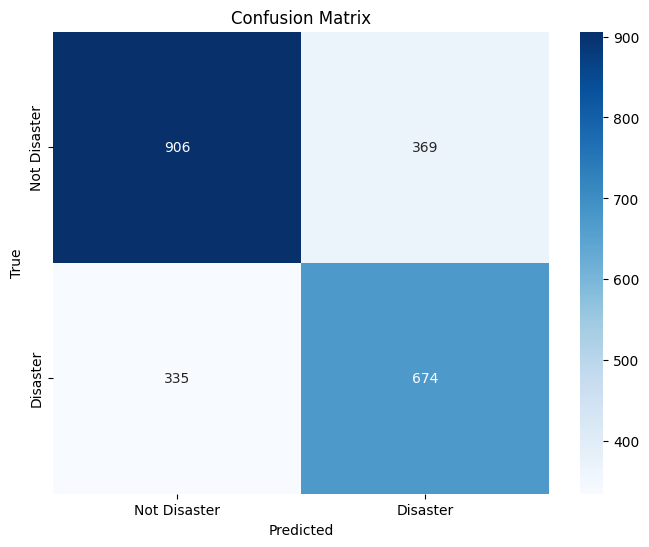

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

#Generating a confusion matrix
def get_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    return cm_df

y_val_pred = best_model[0].predict(val_input)
y_val_pred = np.round(y_val_pred).flatten()

labels = ['Not Disaster', 'Disaster']
cm_df = get_confusion_matrix(val_output, y_val_pred, labels)

#Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## ROC Curve for the best model


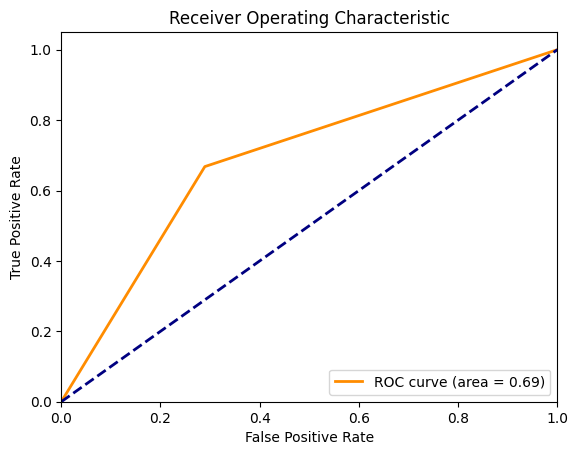

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

#Plotting the ROC curve
def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(val_output, y_val_pred)

##Prepare for submission


In [ ]:
from google.colab import files
df_test_pred = preprocess_text(df_test_text)
test_padded_seq = seq_and_pad(df_test_pred, tokenizer, PADDING, MAXLEN)
df_test_pred = best_model[0].predict(test_padded_seq)
submission['target'] = df_test_pred.round().astype(int)
submission.to_csv('submission.csv', index=False)
files.download('submission.csv')

102/102 [==============================] - 0s 4ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>